[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/liapla/Game-Theory-and-Epidemics/blob/main/COVID19_and_Gametheory_DecisionOnModel.ipynb)

# Importing libraries and plots initialization

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib as mpl
from datetime import datetime
from pandas.tseries.offsets import DateOffset
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from scipy.stats import lognorm
from scipy.special import erf
from scipy import signal
import pandas as pd
import covid19_inference as cov19
import csv
from scipy.interpolate import interp1d
from scipy import optimize
from scipy.optimize import fsolve

# Matplotlib config
# mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["font.sans-serif"] = "Arial"
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["axes.labelcolor"] = "black"
mpl.rcParams["axes.edgecolor"] = "black"
mpl.rcParams["xtick.color"] = "black"
mpl.rcParams["ytick.color"] = "black"
mpl.rcParams["xtick.labelsize"] = 6.5
mpl.rcParams["ytick.labelsize"] = 6.5
mpl.rcParams["axes.labelsize"] = 8
mpl.rcParams["axes.titlesize"] = 8
mpl.rcParams["figure.titlesize"] = 6.5
mpl.rcParams["legend.fontsize"] = 5
mpl.rcParams['figure.dpi'] =300

# Real data as initial conditions

In [3]:
owd = cov19.data_retrieval.OWD(True) #Download data from OWD
owd.data

INFO     [covid19_inference.data_retrieval.retrieval] Successfully downloaded OurWorldinData.csv.gz to /tmp/covid19_data/.
INFO     [covid19_inference.data_retrieval.retrieval] Local backup to /tmp/covid19_data/OurWorldinData.csv.gz successful.


,iso_code,continent,country,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,
2020-02-24,AFG,Asia,Afghanistan,5.0,5.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-25,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-26,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-27,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-28,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-06,ZWE,Africa,Zimbabwe,255805.0,50.0,40.714,5560.0,2.0,1.000,16949.516,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
2022-07-07,ZWE,Africa,Zimbabwe,255805.0,0.0,31.286,5560.0,0.0,0.714,16949.516,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
2022-07-08,ZWE,Africa,Zimbabwe,255891.0,86.0,43.571,5562.0,2.0,1.000,16955.215,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


In [5]:
ger = owd.data[owd.data["country"] == "Germany"] #Filter data for only Germany
ger.fillna(0) #Replace NaN data as 0

,iso_code,continent,country,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,
2020-01-27,DEU,Europe,Germany,1.0,1.0,0.000,0.0,0.0,0.000,0.012,...,28.2,33.1,0.0,8.0,81.33,0.947,0.0,0.0,0.0,0.0
2020-01-28,DEU,Europe,Germany,4.0,3.0,0.000,0.0,0.0,0.000,0.048,...,28.2,33.1,0.0,8.0,81.33,0.947,0.0,0.0,0.0,0.0
2020-01-29,DEU,Europe,Germany,4.0,0.0,0.000,0.0,0.0,0.000,0.048,...,28.2,33.1,0.0,8.0,81.33,0.947,0.0,0.0,0.0,0.0
2020-01-30,DEU,Europe,Germany,4.0,0.0,0.000,0.0,0.0,0.000,0.048,...,28.2,33.1,0.0,8.0,81.33,0.947,0.0,0.0,0.0,0.0
2020-01-31,DEU,Europe,Germany,5.0,1.0,0.000,0.0,0.0,0.000,0.060,...,28.2,33.1,0.0,8.0,81.33,0.947,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-06,DEU,Europe,Germany,28808614.0,135402.0,89679.000,141627.0,108.0,74.571,343366.535,...,28.2,33.1,0.0,8.0,81.33,0.947,0.0,0.0,0.0,0.0
2022-07-07,DEU,Europe,Germany,28926346.0,117732.0,90340.857,141758.0,131.0,81.286,344769.769,...,28.2,33.1,0.0,8.0,81.33,0.947,0.0,0.0,0.0,0.0
2022-07-08,DEU,Europe,Germany,29022265.0,95919.0,89948.000,141862.0,104.0,81.429,345913.016,...,28.2,33.1,0.0,8.0,81.33,0.947,0.0,0.0,0.0,0.0


In [6]:
#Get all features name of the data
ger.columns

Index(['iso_code', 'continent', 'country', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       'total_vacc

Obtaining the initial conditions and parameters

In [13]:
t1 = '2021-01-01'
p0 = ger.loc[t1].population
e0 = ger.loc['2021-01-15'].new_cases_per_million/1e6            #Convolution needed
i0 = ger.loc['2020-12-21':'2021-01-01'].new_cases_per_million.sum()/1e6
d0 = ger.loc[t1].total_deaths_per_million/1e6                   #recovered not included
v0 = ger.loc[t1].total_vaccinations_per_hundred/1e2
s0 = 1-e0-i0-d0-v0

R0 = ger.loc[t1].reproduction_rate
nu = ger.loc[t1].new_people_vaccinated_smoothed_per_hundred/1e2

## Real $d_S$

WARNING  [matplotlib.legend] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


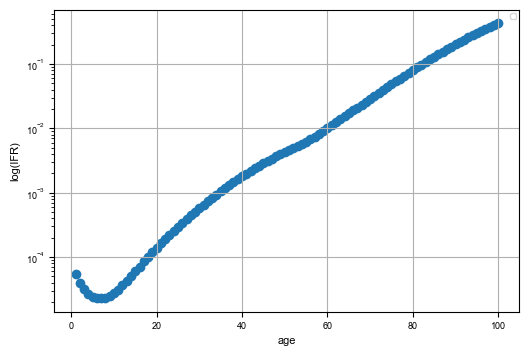

In [15]:
plt.figure(dpi = 100)

x = []
y = []
with open('ifr_age.txt', 'r') as csvfile:
    plots = csv.reader(csvfile, delimiter = ',')
    for row in plots:
        y.append(float(row[1])/100)
        x.append(float(row[0]))
        
plt.scatter(x, y) 
# plt.plot(Ages, np.array(ds_list),color='r')
# plt.scatter(Ages,np.array(ds_list),label='$d_{cov}(age)$' , color='r')

plt.yscale("log")
plt.xlabel(r'age')
plt.ylabel(r'log(IFR)')
plt.grid(True)
plt.legend()
plt.show()

In [16]:
ds_real = np.array(y) #d_s for ages 1 to 100
ds_real

array([5.40000e-05, 4.00000e-05, 3.20000e-05, 2.70000e-05, 2.40000e-05,
       2.30000e-05, 2.30000e-05, 2.30000e-05, 2.50000e-05, 2.80000e-05,
       3.10000e-05, 3.60000e-05, 4.20000e-05, 5.00000e-05, 6.00000e-05,
       7.10000e-05, 8.50000e-05, 1.00000e-04, 1.18000e-04, 1.38000e-04,
       1.62000e-04, 1.88000e-04, 2.19000e-04, 2.54000e-04, 2.93000e-04,
       3.37000e-04, 3.86000e-04, 4.42000e-04, 5.04000e-04, 5.73000e-04,
       6.50000e-04, 7.35000e-04, 8.29000e-04, 9.32000e-04, 1.04600e-03,
       1.17100e-03, 1.30700e-03, 1.45500e-03, 1.61600e-03, 1.78900e-03,
       1.97600e-03, 2.17700e-03, 2.39100e-03, 2.62000e-03, 2.86300e-03,
       3.11900e-03, 3.38900e-03, 3.67200e-03, 3.96800e-03, 4.27800e-03,
       4.60600e-03, 4.95800e-03, 5.34200e-03, 5.76600e-03, 6.24200e-03,
       6.78500e-03, 7.41300e-03, 8.14900e-03, 9.02200e-03, 1.00350e-02,
       1.11620e-02, 1.24130e-02, 1.38030e-02, 1.53460e-02, 1.70580e-02,
       1.89570e-02, 2.10640e-02, 2.33990e-02, 2.59860e-02, 2.885

In [17]:
fun_ds = interp1d(np.arange(1,101),ds_real)

# SEIDV Model

## Constants initialization

In [36]:
R0 = 2             ###Basic reproductive ratio
sigma = 1 / 5      ###1/Mean latent period
gamma = 1 / 20       ###1/Mean infectious period
# t_res = 14          ###Vaccinator response time
# nu = 1e-4           ###Vaccination rate
d_v = 1e-6   ###Probability of death from vaccine
# d_s = 0.3            ###Probability of death from smallpox
# r = 0.01            ###Attack risk (probability)
# alpha = 5000/290000000    ###Attack size (no. of individuals)
beta = gamma * R0   ###Mean transmission rate 
N = 1 #alpha * 100000     ###total population

## SEIDV epidemic model 
In this part we define the epedimic model differential equations and find the numertical solutoin, using the Runge-Kutta method of order 5.

In [19]:
def SEIDV(t,state): #The differential equations of SEIDV model have been defined in this function
    S,E,I,D,V = state
    dSdt = -beta * S * I -nu
    dEdt = beta * S * I - E * sigma
    dIdt = sigma * E - gamma * I
    dDdt = gamma * I
    dVdt = nu
    return [dSdt , dEdt , dIdt , dDdt , dVdt]
    
def epidemiology_model(S0,E0,I0,D0,V0,t_end): #This function solves epidemic model ODEs with Runge-Kutta method of order 5.
  init = [S0,E0,I0,D0,V0]
  time_span = np.linspace(0.001, 99.99, 100)
  solution = solve_ivp(SEIDV,t_span = (0,t_end),y0=init)
  f_s = interp1d(solution.t,solution.y[0], kind = 'cubic')
  f_e = interp1d(solution.t,solution.y[1], kind = 'cubic')
  f_i = interp1d(solution.t,solution.y[2], kind = 'cubic')
  f_d = interp1d(solution.t,solution.y[3], kind = 'cubic')
  f_v = interp1d(solution.t,solution.y[4], kind = 'cubic')
  Time = np.arange(0,t_end+1)
  Solution = [f_s(Time),f_e(Time),f_i(Time),f_d(Time),f_v(Time)]
  return Solution ,Time

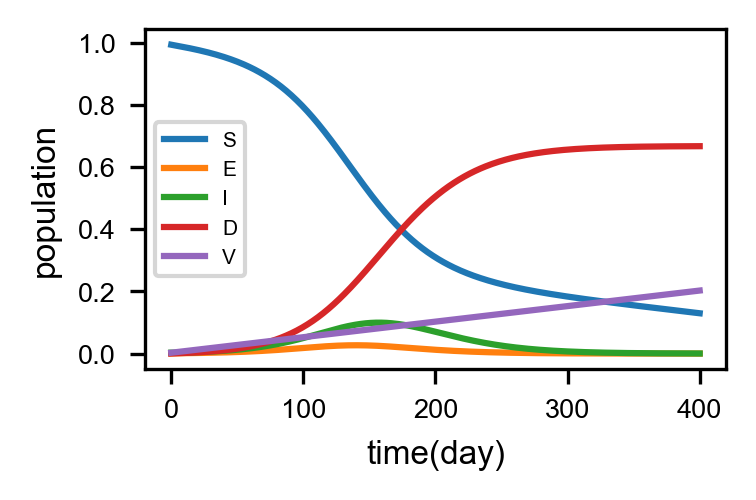

In [20]:
#Model
model , time = epidemiology_model(s0,e0,i0,d0,v0,400)
fig ,ax = plt.subplots(1,1,figsize = (2.5,1.5))
ax.plot(time,model[0] , label = 'S')
ax.plot(time,model[1], label = 'E')
ax.plot(time,model[2], label = 'I')
ax.plot(time,model[3], label = 'D')
ax.plot(time,model[4], label = 'V')
ax.set_ylabel('population')
ax.set_xlabel('time(day)')
# ax.set_title('SEIDV epidemiology model')
ax.legend()

plt.show()

# Age dependent investigation

In [21]:
def E_non_vac_time(age,Infectious):
    i1 = Infectious[0]
    return ds_real[age]*(Infectious-i1)[1:]

def E_non_vac_age(Infectious,t2,t1):
    i1,i2 = Infectious[t1],Infectious[t2]
    return ds_real*(i2-i1)

def E_vac(dv):
    return dv

Text(0, 0.5, 'Total infectious')

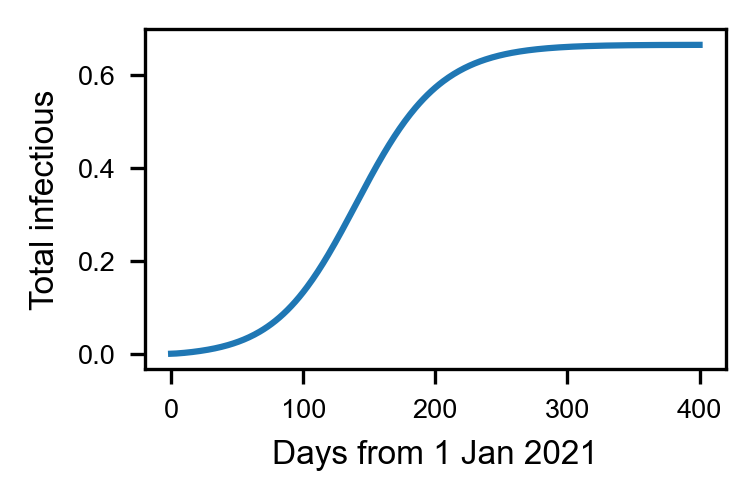

In [22]:
Infectious = model[2]+model[3]
fig ,ax = plt.subplots(1,1,figsize = (2.5,1.5))
ax.plot(Infectious-Infectious[0])
ax.set_xlabel('Days from 1 Jan 2021')
ax.set_ylabel('Total infectious')

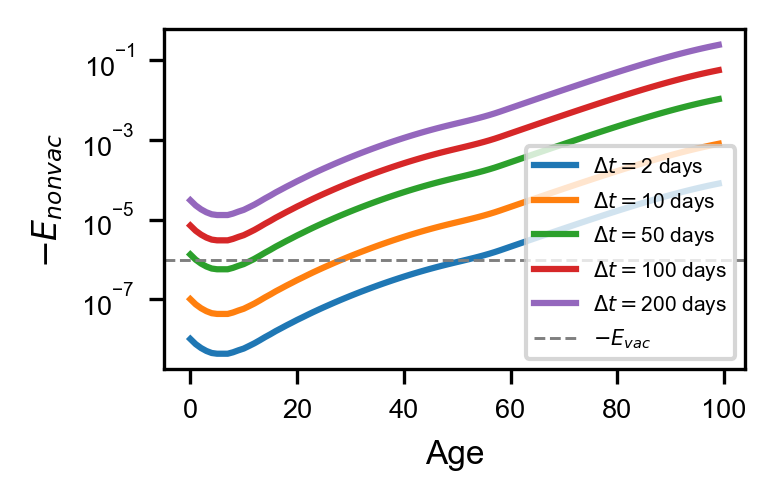

In [25]:
fig ,ax = plt.subplots(1,1,figsize = (2.5,1.5))
ax.plot(-E_non_vac_age(Infectious,0,2),label = '$\Delta t =$2 days')
ax.plot(-E_non_vac_age(Infectious,0,10),label = '$\Delta t =$10 days')
#ax.plot(-E_non_vac_age(Infectious,0,20),label = '20 days')
ax.plot(-E_non_vac_age(Infectious,0,50),label = '$\Delta t =$50 days')
ax.plot(-E_non_vac_age(Infectious,0,100),label = '$\Delta t =$100 days')
ax.plot(-E_non_vac_age(Infectious,0,200),label = '$\Delta t =$200 days')
#ax.plot([0,100],[1e-6,1e-6],label = '$E_{vac}$',ls = '--')
ax.axhline(dv,label = '$-E_{vac}$',ls = '--',color = 'tab:gray',lw = 0.7)
ax.set_yscale("log")
ax.set_xlabel(r'Age')
ax.set_ylabel(r'$-E_{nonvac}$')
ax.legend()


## Nash Equilibrium time $\Delta T$

In [26]:
def NE_time(Infectious,age1,age2):
    Age = np.arange(age1,age2+1)
    dv = 1e-6
    NE_time = []
    for age in Age:
        evac = E_vac(dv)             #Age dependent dv
        Enonvactime = E_non_vac_time(age,Infectious)
        if max(Enonvactime) < dv: ne_time = 100
        elif min(Enonvactime) > dv: ne_time = 0
        else:
            fun = interp1d(np.arange(1,len(Infectious)),Enonvactime-evac)
            ne_time = fsolve(fun,x0 = 50)              #replace t_end as 100
        #print(ne_time)
        NE_time.append(ne_time)
    return NE_time

/Users/ambasscope/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/var/folders/ft/_tx7cb7j5594443_xhsg6y4r0000gn/T/ipykernel_23776/1693224395.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ax.plot(np.array(NE_time(Infectious,age1,age2))/7,np.arange(age1,age2+1))


Text(0.5, 0, '$\\Delta T$ (weeks)')

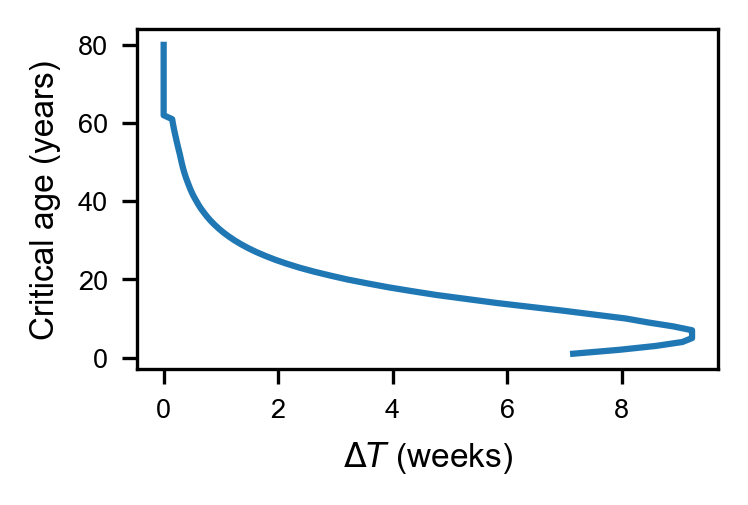

In [27]:
age1 = 1
age2 = 80
fig ,ax = plt.subplots(1,1,figsize = (2.5,1.5))
ax.plot(np.array(NE_time(Infectious,age1,age2))/7,np.arange(age1,age2+1))
ax.set_ylabel('Critical age (years)')
ax.set_xlabel('$\Delta T$ (weeks)')

## Fixed size of window of decision

8.459641000931995e-05


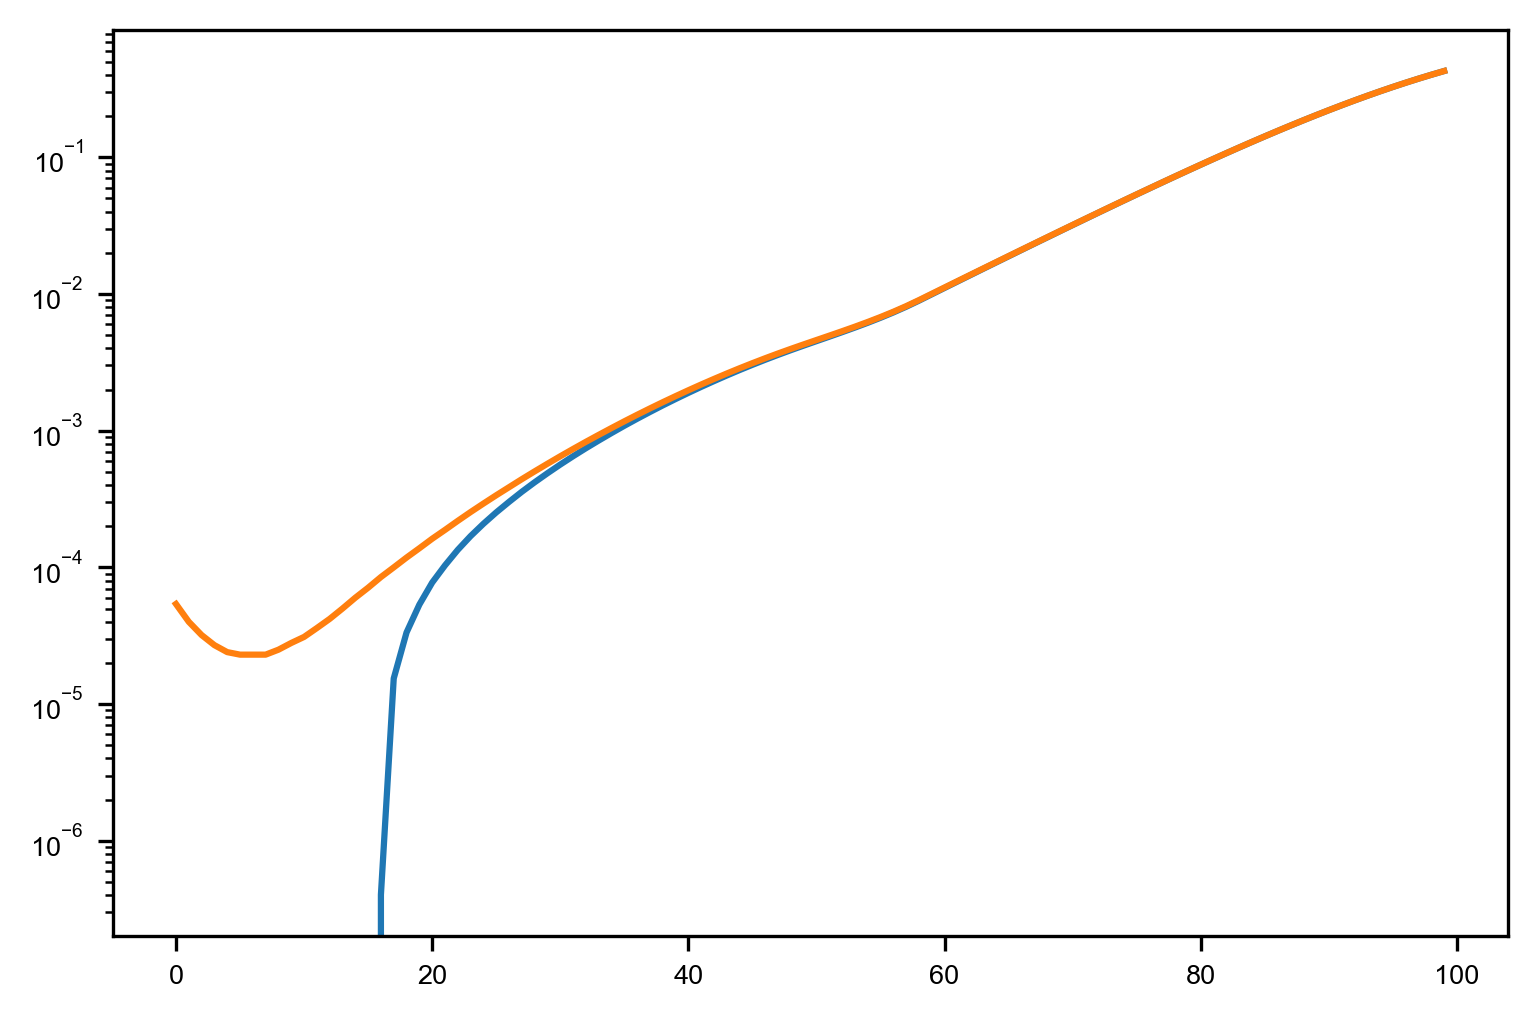

In [24]:
dv = 1e-6
delta_t = 10
t_end = 300
time = 50

ds_crit = dv/(Infectious[time+delta_t]-Infectious[time])
print(ds_crit)
plt.plot(ds_real - ds_crit)
plt.plot(ds_real)
plt.yscale('log')

In [28]:
def NE_age(Infectious,delta_t,t_end):
    Time = np.arange(len(Infectious))
    Time = Time[Time<t_end-delta_t]
    dv = 1e-6
    NE_age = []
    for time in Time:
        ds_crit = dv/(Infectious[time+delta_t]-Infectious[time])
        fun = interp1d(np.arange(1,101),ds_real-ds_crit)
        try: ne_age = fsolve(fun,x0=50)
        except: 
            try: ne_age = fsolve(fun,x0=2)
            except: 
                #ne_age = 100
                ne_age = 0
        # ne_age = np.where(ds_real-ds_crit > 0)[0][0]
        NE_age.append(ne_age)
    return NE_age


/Users/ambasscope/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Text(0, 0.5, 'Critical age (years)')

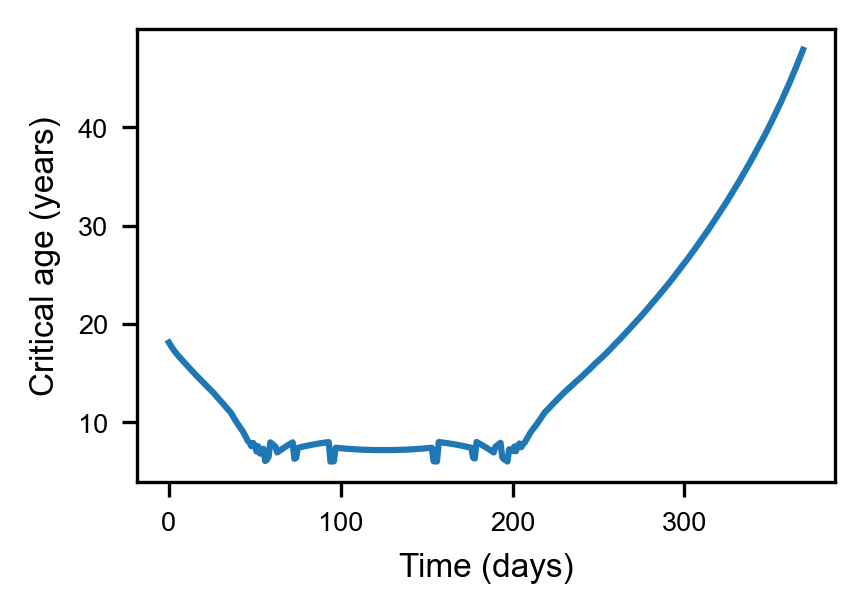

In [29]:
delta_t = 30
t_end = 400

fig, ax = plt.subplots(1,1,figsize = (3,2))
ax.plot(np.arange(0,t_end-delta_t),NE_age(Infectious,delta_t,t_end))
ax.set_xlabel('Time (days)')
ax.set_ylabel('Critical age (years)')

/Users/ambasscope/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[]

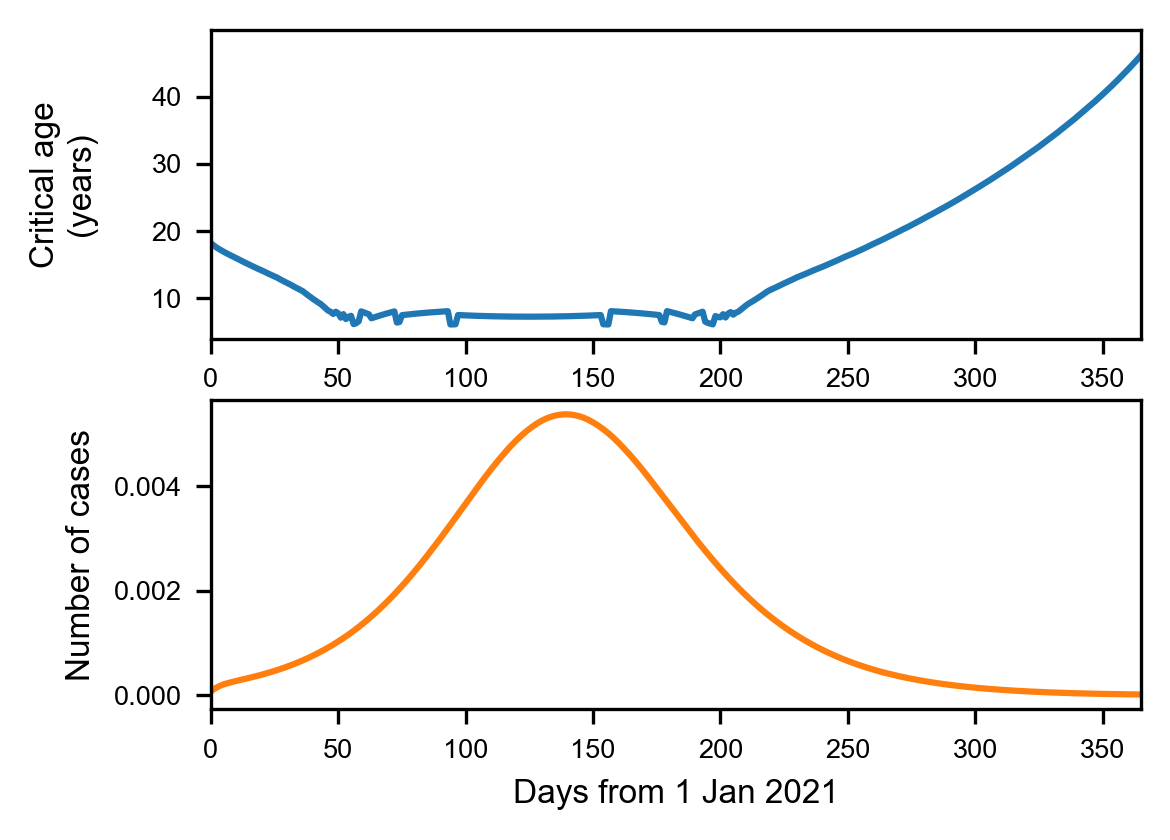

In [35]:
fig , ax = plt.subplots(2,1,figsize=(4,3))
ax[0].plot(NE_age(Infectious,delta_t,t_end))
ax[0].set_ylabel('Critical age\n(years)')
ax[0].set_xlim([0,365])

ax[1].plot(np.diff(Infectious), color = 'tab:orange')
ax[1].set_xlabel('Days from 1 Jan 2021')
ax[1].set_ylabel('Number of cases')
ax[1].set_xlim([0,365])

# ax2 = ax[1].twinx()
# ax2.plot(Infectious, color = 'tab:red')
# ax2.set_ylabel('Cumulative cases', color = 'tab:red')

fig.align_ylabels(ax)
plt.plot()